# Time Series Analysis and Forecast on Perth Fuel Price (2022-2024)

&emsp;The project follows `Box-Jenkins`'s modelling framework that consists of `identification`, `estimation`, `model diagnostic`, and `production` to analyse and make forecast of Perth's fuel prices.

## Table of Contents
1. [Import Library](#lib)
2. [Import Data](#data)  
&emsp;a. [SQL](#sql1)  
&emsp;b. [Pandas](#read_csv)
3. [Data Preparation](#prep)
4. [Modelling](#model)

## Import Library<a id='lib'></a>

In [695]:
# MySQL
import psycopg2
import mysql.connector
# Numpy and Dataframe
import numpy as np
import pandas as pd
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# Stationarity test
from statsmodels.tsa.stattools import adfuller
# Order searching
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# Modelling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Save and load model
import joblib

## Import Data<a id='data'></a>
&emsp;Fuel price data was retrieved from [Fuel Watch](https://www.fuelwatch.wa.gov.au). Multiple Excel files were imported into MySQL database. Only unleaded petrol price in Perth Metro was extracted from the large amount of data for this particular analysis and forecast.

### SQL<a id='sql1'></a>

In [696]:
# Connect database
# mydb = mysql.connector.connect(
#   host="localhost",
#   user="root",
#   password="password"
# )
# mycursor = mydb.cursor()

In [697]:
# Extract dataset
# mycursor.execute(
#     "SELECT date, brand, price\
#     FROM base.WA_fuel\
#     WHERE (fuel = 'ULP') AND (postcode = 6000)"
# )

# result = mycursor.fetchall()

In [698]:
# for x in result:
#     print(x)

In [699]:
# Turn SQL result into dataframe
# df = pd.DataFrame(result, columns=['date','brand','price'])
# print(f"Number of rows: {df.shape[0]}")
# print(f"Number of columns: {df.shape[1]}")
# df.head(10)

### Pandas<a id='read_csv'></a>

In [700]:
df = pd.read_excel('perth_fuel.xlsx').iloc[:,1:]

In [701]:
df.drop_duplicates(inplace=True)
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
df.reset_index(drop=True, inplace=True)
df.head(10)

Number of rows: 7028
Number of columns: 3


,date,brand,price
0,01/01/2019,Caltex,139.7
1,01/01/2019,Coles Express,142.9
2,01/01/2019,Liberty,132.4
3,02/01/2019,Caltex,136.7
4,02/01/2019,Coles Express,140.9
5,02/01/2019,Liberty,132.4
6,03/01/2019,Caltex,133.9
7,03/01/2019,Caltex,134.3
8,03/01/2019,Coles Express,138.9
9,03/01/2019,Liberty,132.4


In [702]:
# Convert date column into datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [703]:
df.head()

,date,brand,price
0,2019-01-01,Caltex,139.7
1,2019-01-01,Coles Express,142.9
2,2019-01-01,Liberty,132.4
3,2019-01-02,Caltex,136.7
4,2019-01-02,Coles Express,140.9


## Data Preparation<a id='prep'></a>

In [704]:
# Congregate data using months
df['month_year'] = df['date'].dt.to_period('M')
df['date'] = df['month_year']

In [705]:
# Group dataset by date and aggregate by price's mean
df_uni = df.groupby(['date'])['price'].agg('mean')
# Narrow down to 3 years data
df_uni = df_uni[36:]

### Stationarity

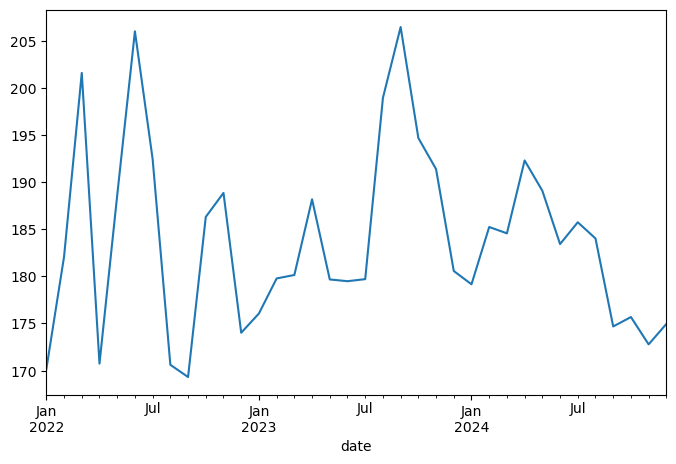

(-4.234677265656118,
 0.0005752858233488169,
 0,
 35,
 {'1%': -3.6327426647230316,
  '5%': -2.9485102040816327,
  '10%': -2.6130173469387756},
 168.75827250557106)

In [706]:
# Testing trend stationarity
fig, ax = plt.subplots(figsize=(8,5))
df_uni.plot(ax=ax)
plt.show()

adfuller(df_uni)

Without differencing, $p$ value is .0006 and the test statistic is -4.235. Thus, null hypothesis that the time series is non-stationary can be rejected.

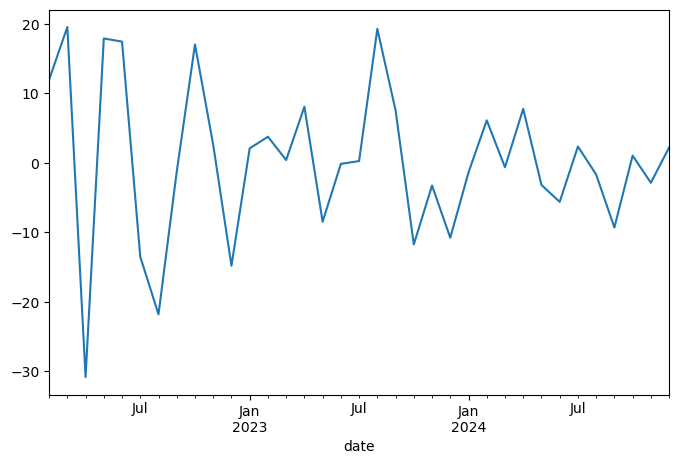

(-6.475027684774487,
 1.3377543336667251e-08,
 0,
 34,
 {'1%': -3.639224104416853,
  '5%': -2.9512301791166293,
  '10%': -2.614446989619377},
 163.8711532980028)

In [707]:
# Take first difference and test again
df_uni_1diff = df_uni.diff(1).dropna()

fig, ax = plt.subplots(figsize=(8,5))
df_uni_1diff.plot(ax=ax)
plt.show()

adfuller(df_uni_1diff)

Taking first differencing makes the time series more stationary.

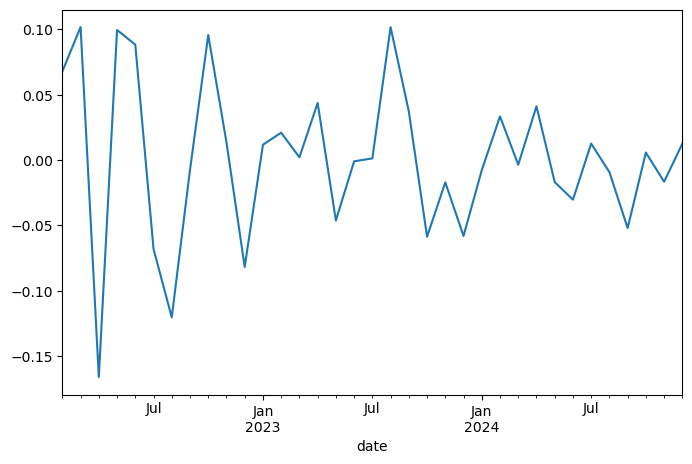

(-6.485244558881927,
 1.2656677804100626e-08,
 0,
 34,
 {'1%': -3.639224104416853,
  '5%': -2.9512301791166293,
  '10%': -2.614446989619377},
 -87.57685500593283)

In [708]:
# Try log-return and test again
df_uni_logreturn = np.log(df_uni/df_uni.shift(1)).dropna()

fig, ax = plt.subplots(figsize=(8,5))
df_uni_logreturn.plot(ax=ax)
plt.show()

adfuller(df_uni_logreturn)

Log-return produces similar result. However, I will stick to the original time-series for the following analysis and forecast.

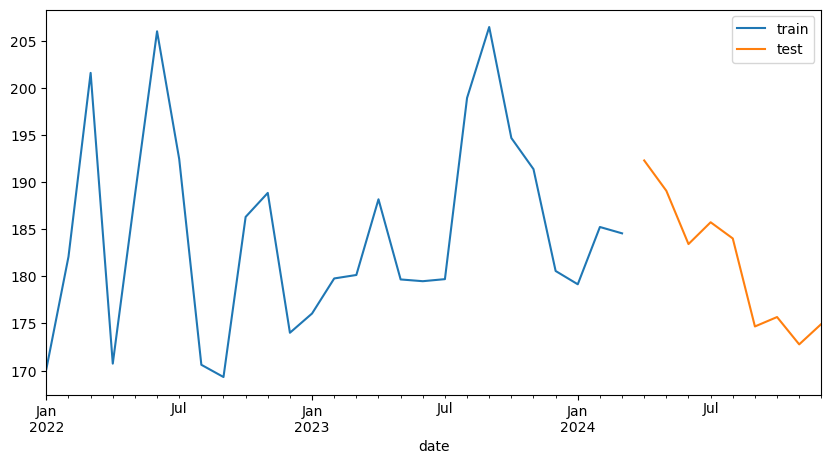

In [734]:
# Train test split
train = df_uni.iloc[:round(df_uni.shape[0]*.75)]
test = df_uni.iloc[round(df_uni.shape[0]*.75):]

fig, ax = plt.subplots(figsize=(10,5))
train.plot(label='train', ax=ax)
test.plot(label='test', ax=ax)
plt.legend()
plt.show()

## Modelling<a id='model'></a>

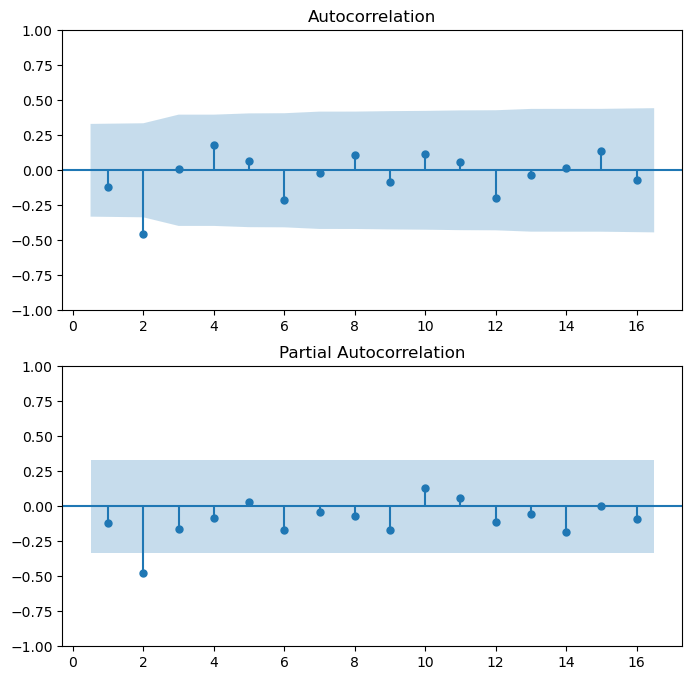

In [710]:
# plot ACF and PACF graphs
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

plot_acf(df_uni_1diff, lags=16, zero=False, ax=ax1) # lags=25
plot_pacf(df_uni_1diff, lags=16, zero=False, ax=ax2)
plt.show()

&emsp;The ACF and PACF plots both did do not show signs of tailing off. The determination of orders is inconclusive.

In [711]:
# Search for the best order by AIC and BIC
order_aic_bic = []

for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(df_uni, order=(p,0,q))
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
        except:
            order_aic_bic.append((p, q, None, None))

order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: M

In [712]:
order_df.sort_values(['aic', 'bic'])

,p,q,aic,bic
14,2,4,262.305881,274.974033
1,0,1,263.050729,267.801285
6,1,1,263.078849,269.412925
2,0,2,263.368854,269.702930
12,2,2,264.743452,274.244565
7,1,2,265.061934,272.979529
11,2,1,265.069283,272.986877
3,0,3,265.196621,273.114216
8,1,3,265.226557,274.727670
10,2,0,265.638831,271.972906


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                   36
Model:                 ARIMA(2, 0, 4)   Log Likelihood                -123.153
Date:                Thu, 26 Dec 2024   AIC                            262.306
Time:                        15:36:27   BIC                            274.974
Sample:                    01-31-2022   HQIC                           266.727
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        184.8976      0.301    613.730      0.000     184.307     185.488
ar.L1          1.9165      0.071     27.004      0.000       1.777       2.056
ar.L2         -0.9920      0.086    -11.602      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


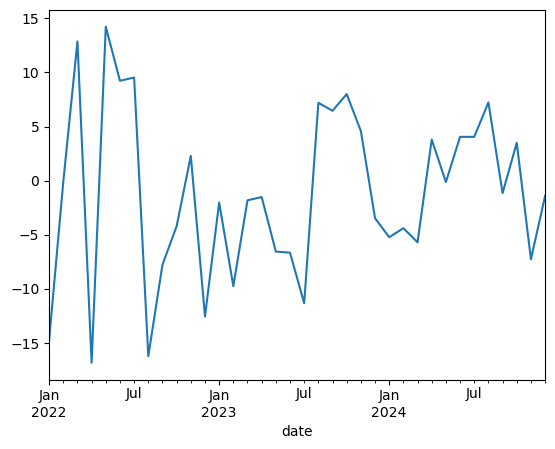

MAE:6.604223539729192


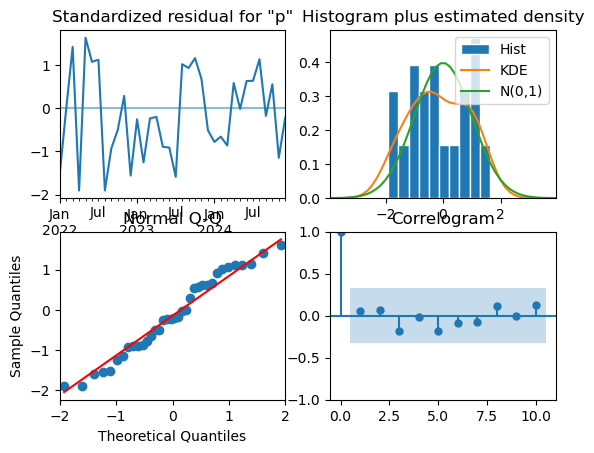

count    36.000000
mean     -1.215332
std       8.021223
min     -16.821059
25%      -6.577063
50%      -1.460737
75%       4.182756
max      14.224853
dtype: float64


In [713]:
# fit model
model = ARIMA(df_uni, order=(2,0,4)) # order=(2,1,0)
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = model_fit.resid
residuals.plot()
plt.show()
# Mean absolute error (MAE)
mae = np.mean(np.abs(residuals))
print(f'MAE:{mae}')
# density plot of residuals - white Gaussian noise should be centred around 0
model_fit.plot_diagnostics()
plt.show()
# residuals.plot(kind='kde')
# plt.show()
# summary stats of residuals
print(residuals.describe())

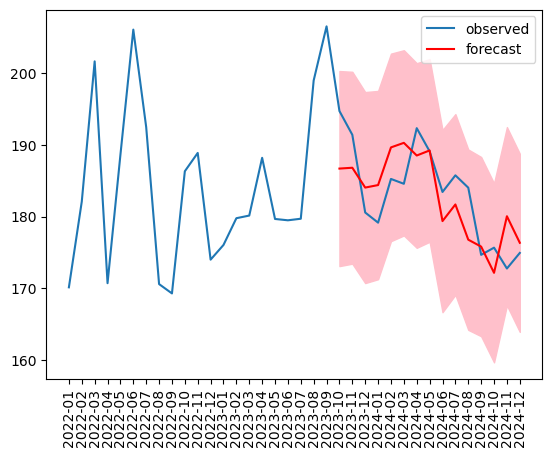

In [714]:
# Forecast (one-step ahead in-sample prediction)
forecast = model_fit.get_prediction(start=-15) # start = -25
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure()
plt.plot(df_uni.index.to_series().astype('str'), df_uni, label='observed')
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
# X-axis tick labels
plt.xticks(rotation=90)
plt.legend()
plt.show()

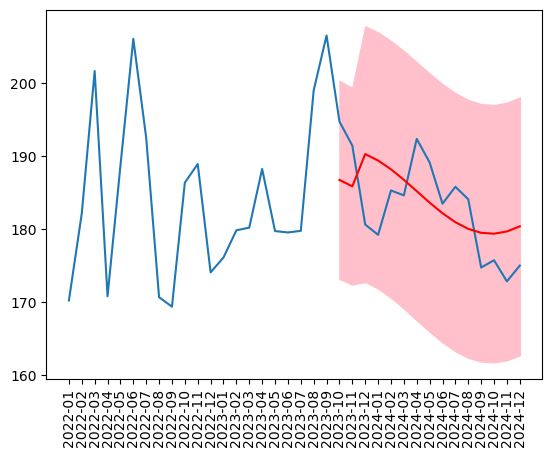

In [715]:
# Forecast (Dynamic in-sample prediction)
forecast = model_fit.get_prediction(start=-15, dynamic=True) # start=-25
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure()
plt.plot(df_uni.index.to_series().astype('str'), df_uni)
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
# X-axis tick labels
plt.xticks(rotation=90)
plt.show()

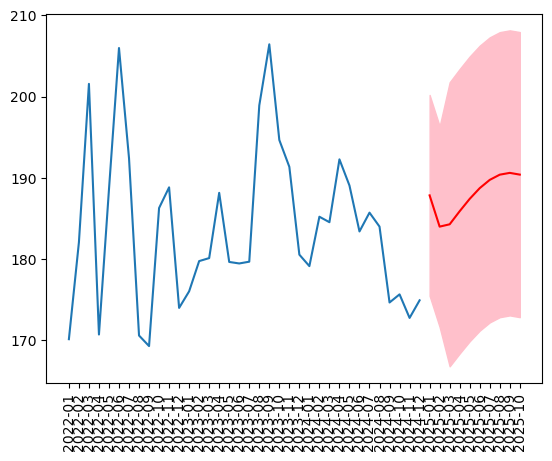

In [716]:
# Forecast (Out-sample prediction)
forecast = model_fit.get_forecast(steps=10)
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure()
plt.plot(df_uni.index.to_series().astype('str'), df_uni)
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
# X-axis labels
plt.xticks(rotation=90)
plt.show()

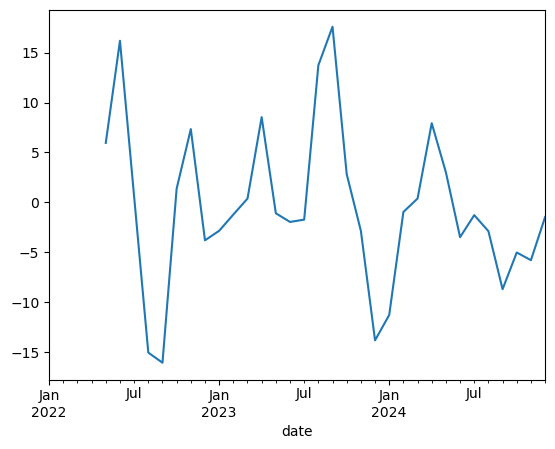

In [717]:
# De-trend the time-series to determine the cycle period
df_detrend = df_uni - df_uni.rolling(5).mean()
df_detrend.dropna()
df_detrend.plot()
plt.show()

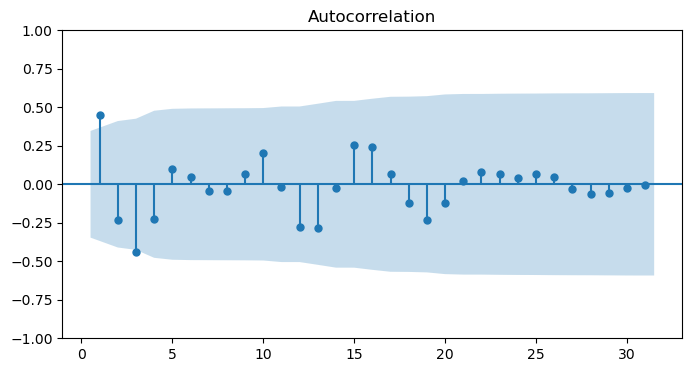

In [718]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

plot_acf(df_detrend.dropna(), lags=31, zero=False, ax=ax) # lags=67
plt.show()

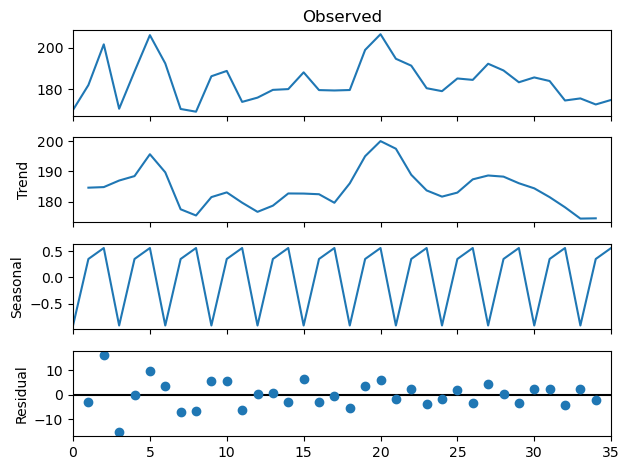

In [719]:
decomp_results = seasonal_decompose(df_uni.values, period=3) # period=4
decomp_results.plot()
plt.show()

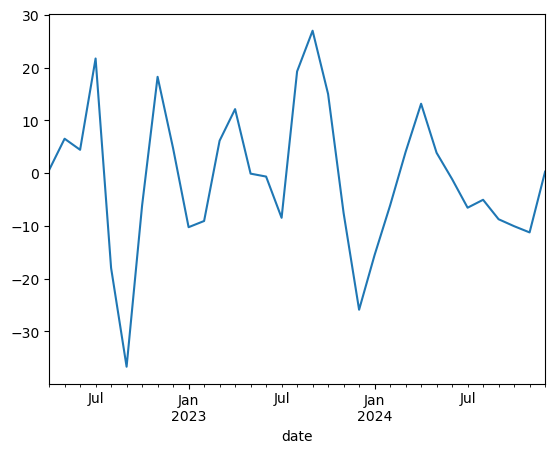

In [720]:
# Seasonal differencing 
df_uni_season_diff = df_uni.diff(3).dropna() # .diff(4)
df_uni_season_diff.plot()
plt.show()

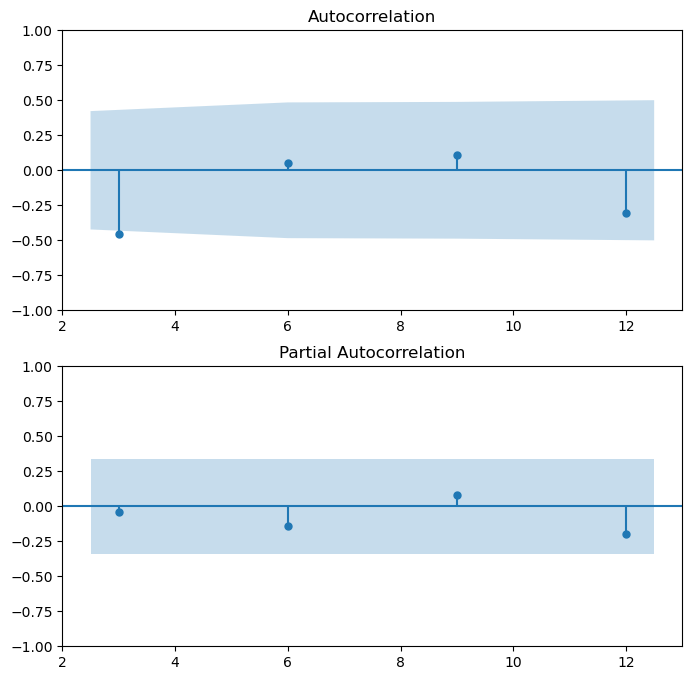

In [721]:
# plot seasonal ACF and PACF graphs
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
lags = [i for i in range(3,15,3)]
plot_acf(df_uni_season_diff, lags=lags, ax=ax1)
plot_pacf(df_uni_season_diff, lags=lags, ax=ax2)
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57973D+00    |proj g|=  3.59562D-01

At iterate    5    f=  3.45701D+00    |proj g|=  6.62961D-02

At iterate   10    f=  3.39367D+00    |proj g|=  4.62161D-02

At iterate   15    f=  3.37231D+00    |proj g|=  1.16965D-02

At iterate   20    f=  3.36307D+00    |proj g|=  2.50627D-02

At iterate   25    f=  3.36064D+00    |proj g|=  5.30816D-03

At iterate   30    f=  3.36021D+00    |proj g|=  1.62760D-02

At iterate   35    f=  3.36013D+00    |proj g|=  7.33693D-04

At iterate   40    f=  3.36011D+00    |proj g|=  2.68059D-03

At iterate   45    f=  3.36010D+00    |proj g|=  7.18774D-04

At iterate   50    f=  3.36010D+00    |proj g|=  1.28744D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


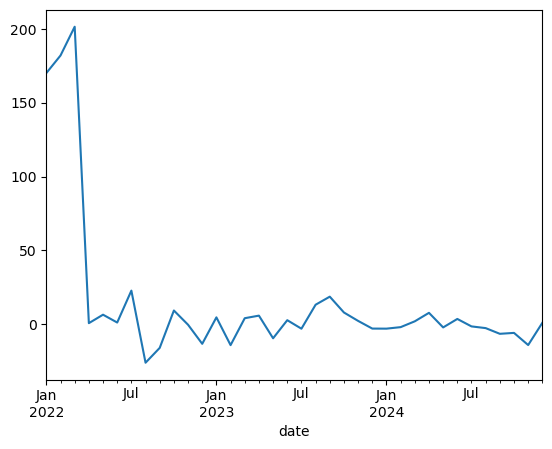

MAE:21.970933811962826


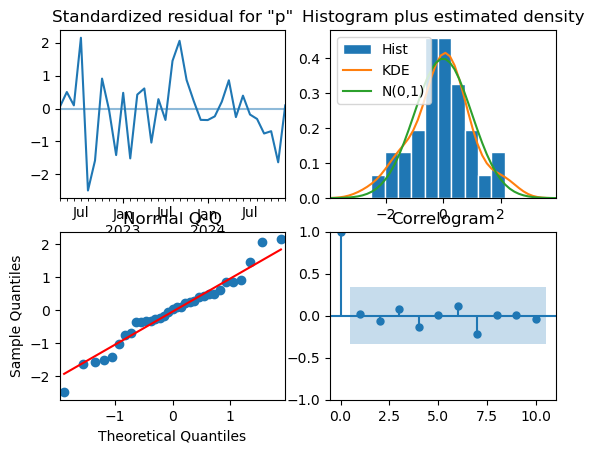

count     36.000000
mean      15.003959
std       52.850106
min      -26.238388
25%       -3.143073
50%        0.916343
75%        6.639996
max      201.575370
dtype: float64


In [722]:
# Apply SARIMA to capture seasonal patterns
model = SARIMAX(df_uni, order=(2,0,4), seasonal_order=(0,1,0,3)) # order=(2,1,0), seasonal_order=(4,1,0,4)
results = model.fit()

# summary of fit model
print(results.summary())
# line plot of residuals
residuals = results.resid
residuals.plot()
plt.show()
# Mean absolute error (MAE)
mae = np.mean(np.abs(residuals))
print(f'MAE:{mae}')
# density plot of residuals - white Gaussian noise should be centred around 0
results.plot_diagnostics()
plt.show()
# residuals.plot(kind='kde')
# plt.show()
# summary stats of residuals
print(residuals.describe())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[3] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=268.878, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=261.218, Time=0.01 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=252.643, Time=0.01 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=267.034, Time=0.00 sec
 ARIMA(0,0,1)(0,1,0)[3] intercept   : AIC=258.483, Time=0.01 sec
 ARIMA(0,0,1)(1,1,1)[3] intercept   : AIC=254.180, Time=0.02 sec
 ARIMA(0,0,1)(0,1,2)[3] intercept   : AIC=254.146, Time=0.04 sec
 ARIMA(0,0,1)(1,1,0)[3] intercept   : AIC=255.197, Time=0.02 sec
 ARIMA(0,0,1)(1,1,2)[3] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,1,1)[3] intercept   : AIC=259.069, Time=0.02 sec
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,2)(0,1,1)[3] intercept   : AIC=252.900, Time=0.02 sec
 ARIMA(1,0,0)(0,1,1)[3] intercept   : AIC=257.411, Time=0.02 sec
 ARIMA(1,0,2)(0,1,1)[3] intercept   : AIC=inf, Time=0.09 se

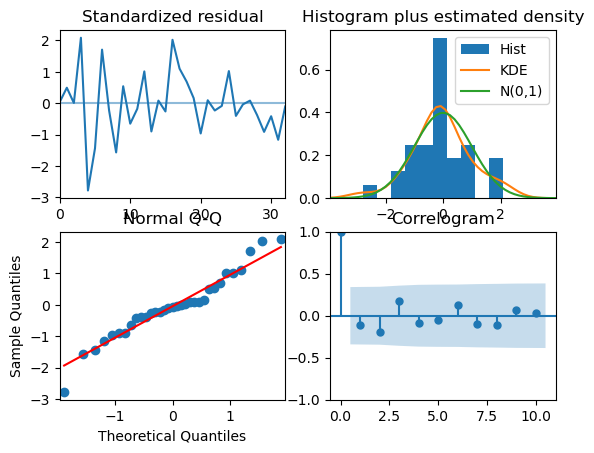

MAE: 21.936323287445564


['model.pkl']

In [724]:
# Searching over model orders
results = pm.auto_arima(df_uni.values, seasonal=True, d=0, m=3, D=1, information_criterion='aic', trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
# Update parameters with new observations
# results.update(df_new)
print(results.summary())
results.plot_diagnostics()
plt.show()

print(f'MAE: {np.mean(np.abs(results.resid()))}')

joblib.dump(results, "model.pkl")

# Load model
# model_results_object = joblib.load("model.pkl")

In [660]:
results

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(0, 1, 1, 3),
      suppress_warnings=True, with_intercept=False)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44620D+00    |proj g|=  2.57950D-02

At iterate    5    f=  3.39930D+00    |proj g|=  5.71196D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   6.116D-07   3.399D+00
  F =   3.3990329090731057     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                     
Dep. Variable:                            

 This problem is unconstrained.


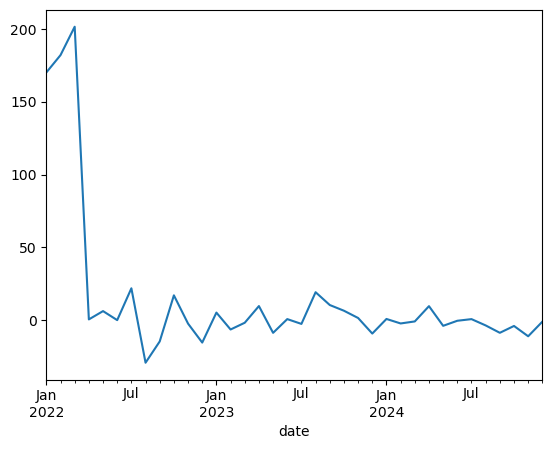

MAE:21.936323287445564


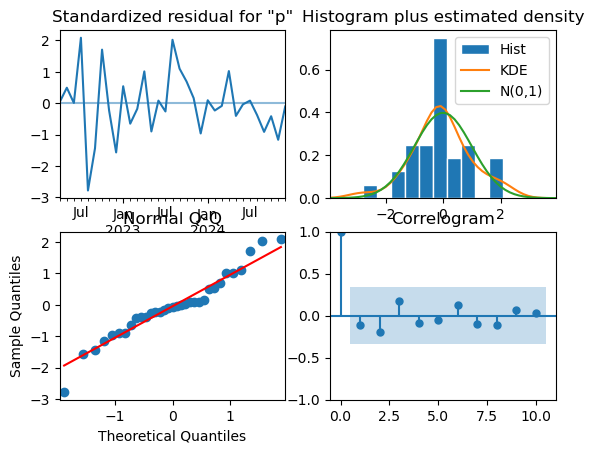

count     36.000000
mean      14.990797
std       52.902300
min      -29.166872
25%       -3.848761
50%       -0.136204
75%        7.321810
max      201.567982
dtype: float64


In [ ]:
# Apply SARIMA to capture seasonal patterns
model = SARIMAX(df_uni, order=(0,0,1), seasonal_order=(0,1,1,3)) # order=(0,1,0), seasonal_order=(1,1,0,4)
results = model.fit()

# summary of fit model
print(results.summary())
# line plot of residuals
residuals = results.resid
residuals.plot()
plt.show()
# Mean absolute error (MAE)
mae = np.mean(np.abs(residuals))
print(f'MAE:{mae}')
# density plot of residuals - white Gaussian noise should be centred around 0
results.plot_diagnostics()
plt.show()
# residuals.plot(kind='kde')
# plt.show()
# summary stats of residuals
print(residuals.describe())

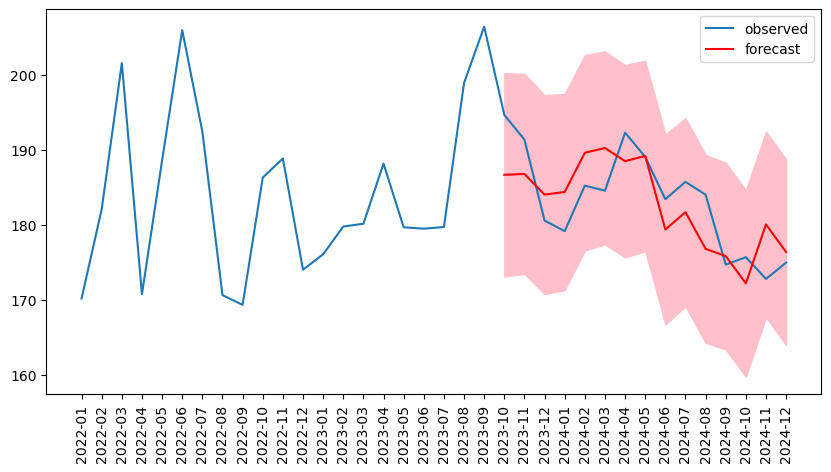

In [ ]:
# Forecast (one-step ahead in-sample prediction)
forecast = model_fit.get_prediction(start=-15) # start=-25
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_uni.index.to_series().astype('str'), df_uni, label='observed')
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
# X-axis labels
plt.xticks(df_uni.index.to_series().astype('str'), rotation=90)
plt.legend()
plt.show()

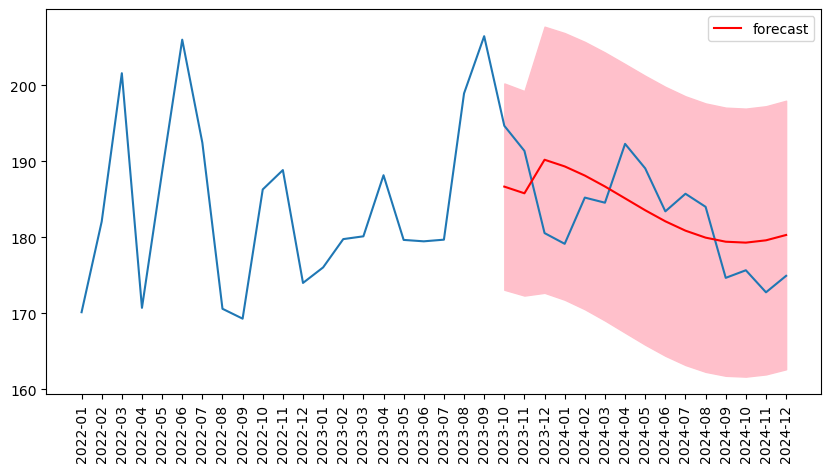

In [663]:
# Forecast (Dynamic in-sample prediction)
forecast = model_fit.get_prediction(start=-15, dynamic=True) # start=-25
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_uni.index.to_series().astype('str'), df_uni)
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
# X-axis labels
plt.xticks(df_uni.index.to_series().astype('str'), rotation=90)
plt.legend()
plt.show()

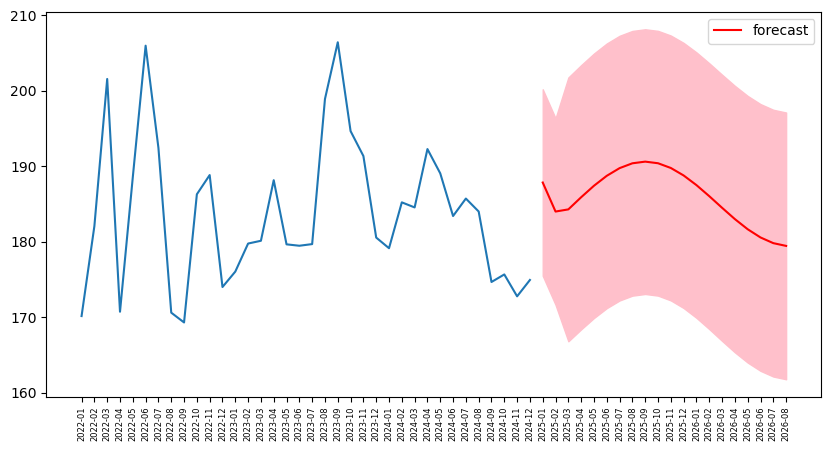

In [664]:
# Forecast (Out-sample prediction)
forecast = model_fit.get_forecast(steps=20)
# Mean forecast
mean_forecast = forecast.predicted_mean
# Confident intervals
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_uni.index.to_series().astype('str'), df_uni)
# Prediction
plt.plot(mean_forecast.index.to_series().astype('str'), mean_forecast.values, color='red', label='forecast')
# Uncertainty area
plt.fill_between(mean_forecast.index.to_series().astype('str'), conf_int['lower price'], conf_int['upper price'], color='pink')
# X-axis labels
plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.show()

In [ ]:
# Connect database for weather data
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="password"
)
mycursor = mydb.cursor()

# Extract dataset
mycursor.execute(
    "SELECT CONCAT(year, '-', month) AS month, ROUND(AVG(temp_max), 1) AS temp_max\
    FROM base.weather\
    WHERE year >= 2019\
    GROUP BY year, month\
    LIMIT 5"
)

result = mycursor.fetchall()

for x in result:
    print(x)

('2019-01', 30.5)
('2019-02', 31.3)
('2019-03', 30.1)
('2019-04', 25.6)
('2019-05', 22.2)
